# import libraries

In [1]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

# EDA

#### In the beginning, We will display the data and do some data visualization ..

In [2]:
path  = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

In [3]:
dataset = {"image_path":[],"img_status":[],"where":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

,image_path,img_status,where
0,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
1,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
2,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
3,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
4,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
...,...,...,...
139995,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
139996,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
139997,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
139998,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train


In [4]:
dataset.value_counts("img_status")

img_status
fake    70000
real    70000
dtype: int64

Real: 70000,
Fake: 70000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


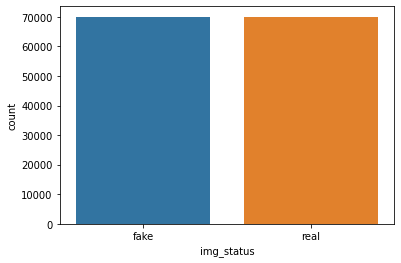

In [5]:
real = dataset.value_counts("img_status")[1]
fake = dataset.value_counts("img_status")[0]

print(f"Real: {real},\nFake: {fake}\n")
sns.countplot(dataset["img_status"])
plt.show()

#### As we can see the data is balanced, We have 70000 image for each category.

#### And here is some random samples from the data .. 

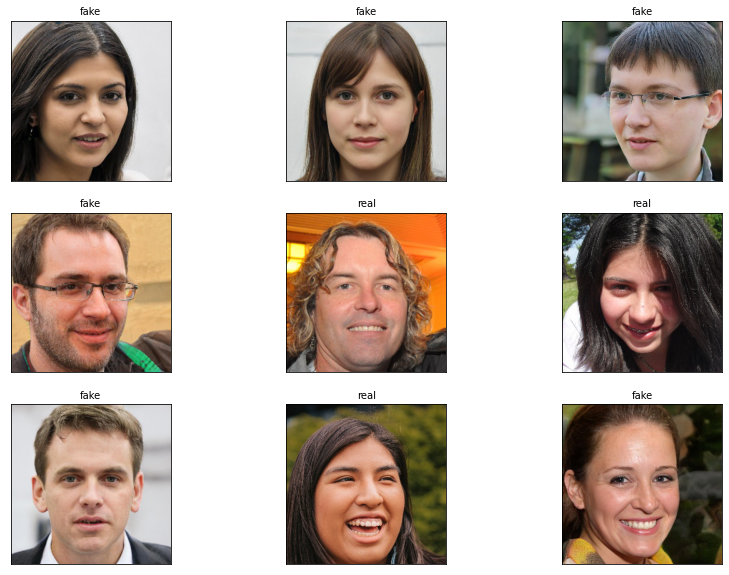

In [6]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "img_status"], size = 10) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# Preprocessing

#### Know we will split the data by the generator to train,test and validation.

In [7]:
image_gen = ImageDataGenerator()

In [8]:
train_generator = image_gen.flow_from_directory(
    path + 'train/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [9]:
valid_generator = image_gen.flow_from_directory(
    path + 'valid/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [10]:
test_generator = image_gen.flow_from_directory(
    path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


# Modeling

### Classify The Model

In [11]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(224,224,1) )

In [12]:
model = Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

In [13]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7031232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = valid_generator,
    validation_steps = (20000//100),
    epochs = 10
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1000/1000 [==============================] - 862s 841ms/step - loss: 0.5084 - accuracy: 0.7434 - val_loss: 0.4765 - val_accuracy: 0.7757
Epoch 2/10
1000/1000 [==============================] - 556s 556ms/step - loss: 0.2731 - accuracy: 0.8838 - val_loss: 0.2792 - val_accuracy: 0.8819
Epoch 3/10
1000/1000 [==============================] - 548s 548ms/step - loss: 0.1534 - accuracy: 0.9391 - val_loss: 0.5970 - val_accuracy: 0.7973
Epoch 4/10
1000/1000 [==============================] - 550s 550ms/step - loss: 0.0942 - accuracy: 0.9642 - val_loss: 0.2642 - val_accuracy: 0.8860
Epoch 5/10
1000/1000 [==============================] - 550s 550ms/step - loss: 0.0628 - accuracy: 0.9763 - val_loss: 0.3335 - val_accuracy: 0.8759
Epoch 6/10
1000/1000 [==============================] - 554s 554ms/step - loss: 0.0448 - accuracy: 0.9831 - val_loss: 0.1249 - val_accuracy: 0.9527
Epoch 7/10
1000/1000 [==============================] - 548s 548ms/step - loss: 0.0362 - accuracy: 0.9870 - val_

In [16]:
model.save('Real VS Fake.h5')

In [17]:
#load_model('./Real VS Fake.h5')

### Model evaluation

In [18]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

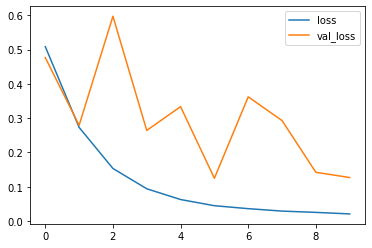

In [19]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

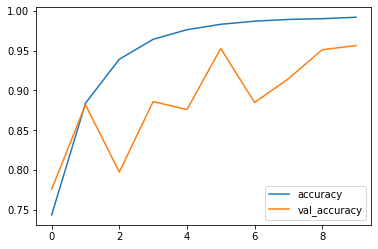

In [20]:
losses[['accuracy','val_accuracy']].plot()

### prediction

In [21]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

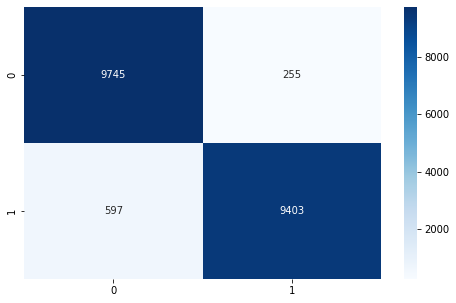

In [22]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [23]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.99327151
AP Score: 0.9928469530083728


In [24]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     10000
           1       0.97      0.94      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

